In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate
from lmfit.models import PseudoVoigtModel

from ramandecompy import dataprep
from ramandecompy import spectrafit
from ramandecompy import datavis

In [2]:
hdf5_filename = 'spectrafit_dev3.hdf5'
key = '300C/25s'

In [3]:
# dataprep.new_hdf5('spectrafit_dev3')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_35s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_45s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_55s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_65s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model. Results saved to spectrafit_dev3.hdf5.


In [ ]:
# hdf5 = h5py.File(hdf5_filename, 'r+')
# del hdf5['300C/25s']
# hdf5.close()

**** spectrafit_dev3.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber
|    35s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber
|    45s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |  

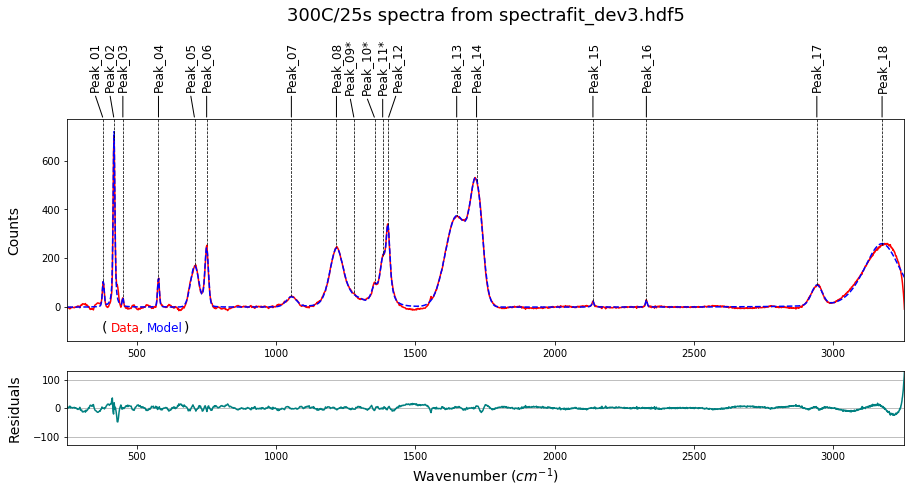

In [8]:
dataprep.view_hdf5(hdf5_filename)
fig, ax1, ax2 = datavis.plot_fit(hdf5_filename, key)
# datavis.plot_components(ax1, hdf5_filename, key, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

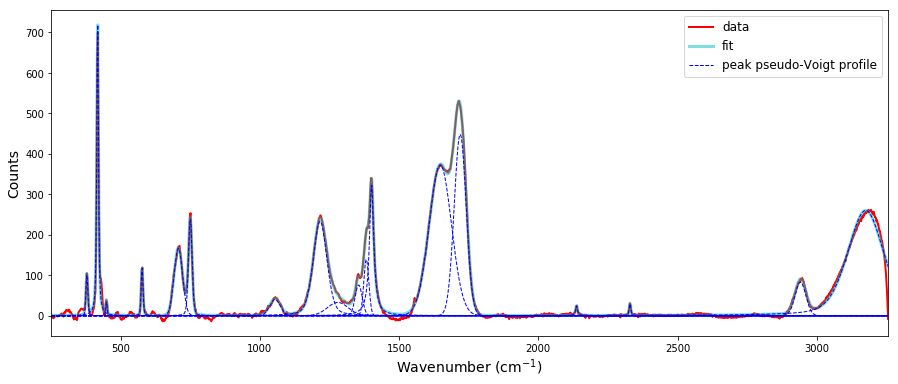

In [5]:
add_list = [1270, 1350, 1385]#, 1640]
# add_list = None
drop_list = ['Peak_01']#, 'Peak_02']
# drop_list = None

dataprep.adjust_peaks(hdf5_filename, key, add_list, drop_list, plot_fits=True)

Test to see if applying an existing fit to the next spectra -----------v

In [6]:
def apply_old_model(x_data, y_data, peaks, plot_fits):
    """
    This function is primarily utilized via the dataprep.adjust_peaks function. It allows a custom
    lmfit.model.CompositeModel to be generated using a list of accepted peak values and a list of
    new peak values to be added based on user experience and expertise. User input peaks are
    slightly less constrained than those automatically detected using local maximia and therefore
    their center (wavenumber) value may shift slighty to optimize the fit.

    Args:
        x_data (list like): The x-values of the spectra from which peaks will be detected.
        y_data (list like): The y-values of the spectra from which peaks will be detected.
        peaks (list): A list containing tuples of the x_data (wavenumber) and y_data (counts)
                      values of the peaks.
        peaks_add (list): A list containing user specified peak locations to be added to the fit
                      as well as interpolated values to provide an initial height guess.
        plot_fits (boolean): A simple True/False boolean input that determins if the plot_fit
                      function should be used to display the resulting fit for visual inspection.

    Returns:
        fit_result (list): An array containing both the peak number, as well as the
                        fraction Lorentzian character, sigma, center, amplitude, full-width,
                        half-max, and the height of the peaks. The data for peak i can be
                        accessed by the array positions shown here:
                            fit_result[i][0] = p[i]_fraction
                            fit_result[i][1] = p[i]_simga
                            fit_result[i][2] = p[i]_center
                            fit_result[i][3] = p[i]_amplitude
                            fit_result[i][4] = p[i]_fwhm
                            fit_result[i][5] = p[i]_height
                            fit_result[i][6] = p[i]_area under the curve

    """
    # add old peaks to the model
    old_peak_list = []
    for i, old_peak in enumerate(peaks):
        prefix = 'p{}_'.format(i+1)
        peak = PseudoVoigtModel(prefix=prefix)
        if i == 0:
            pars = peak.make_params()
        else:
            pars.update(peak.make_params())
        pars[prefix+'fraction'].set(old_peak[0])
        pars[prefix+'center'].set(old_peak[2], vary=True,
                                  min=(old_peak[2]-10), max=(old_peak[2]+10))
        pars[prefix+'height'].set(min=0.1*old_peak[5])
        pars[prefix+'sigma'].set(old_peak[1], min=0.9*old_peak[1], max=1.1*old_peak[1])
        pars[prefix+'amplitude'].set(old_peak[3], min=0)
        old_peak_list.append(peak)
        if i == 0:
            mod = old_peak_list[i]
        else:
            mod = mod + old_peak_list[i]
    # run the fit
    out = spectrafit.model_fit(x_data, y_data, mod, pars, report=False)
    # plot_fits option
    if plot_fits is True:
        spectrafit.plot_fit(x_data, y_data, out, plot_components=True)
    else:
        pass
    # save fit data
    fit_result, residuals = spectrafit.export_fit_data(x_data, y_data, out)
    # add 'user_added' label as 8th term to user added peaks
    for i in range(len(peaks), len(fit_result)):
        fit_result[i].append('user_added')
    # sort peaks by center location for saving
    fit_result = sorted(fit_result, key=lambda x: int(x[2]))
    return fit_result, residuals

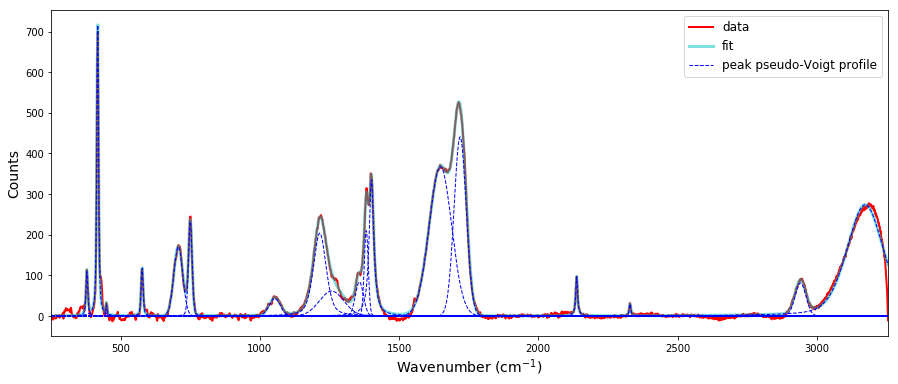

In [11]:
existing_key = '300C/55s'
new_key = '300C/65s'

add_list = None
drop_list = None
hdf5_file = 'spectrafit_dev3.hdf5'

hdf5 = h5py.File(hdf5_file, 'r+')
# extract raw x-y data from new spectra to fit
x_data = np.asarray(hdf5['{}/{}'.format(new_key, 'wavenumber')])
y_data = np.asarray(hdf5['{}/{}'.format(new_key, 'counts')])
# extract peak descriptor tuples from hdf5
peaks = []
for _, peak in enumerate(list(hdf5[existing_key])[:-3]):
    peak_values = hdf5['{}/{}'.format(existing_key, peak)][0]
    peaks.append(list(peak_values)[:7])
# build new model starting with the old one
fit_result, residuals = apply_old_model(x_data, y_data, peaks, plot_fits=True)
# delete old fit data
del hdf5[new_key]
# write data to .hdf5
hdf5['{}/wavenumber'.format(new_key)] = x_data
hdf5['{}/counts'.format(new_key)] = y_data
hdf5['{}/residuals'.format(new_key)] = residuals
for i, result in enumerate(fit_result):
    # create custom datatype
    my_datatype = np.dtype([('fraction', np.float),
                    ('center', np.float),
                    ('sigma', np.float),
                    ('amplitude', np.float),
                    ('fwhm', np.float),
                    ('height', np.float),
                    ('area under the curve', np.float)])
    if len(result) == 7:
        if i < 9:
            dataset = hdf5.create_dataset('{}/Peak_0{}'.format(new_key, i+1), (1,), dtype=my_datatype)
        else:
            dataset = hdf5.create_dataset('{}/Peak_{}'.format(new_key, i+1), (1,), dtype=my_datatype)
    elif len(result) == 8:
        if i < 9:
            dataset = hdf5.create_dataset('{}/Peak_0{}*'.format(new_key, i+1), (1,), dtype=my_datatype)
        else:
            dataset = hdf5.create_dataset('{}/Peak_{}*'.format(new_key, i+1), (1,), dtype=my_datatype)
    else:
        print('fit_result for Peak_{} contains an inappropriate number of values'.format(i))
    # apply data to tuple
    data = tuple(result[:7])
    data_array = np.array(data, dtype=my_datatype)
    # write new values to the blank dataset
    dataset[...] = data_array
hdf5.close()
